In [1]:
#Imports Libraies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib


In [2]:
#Load the dataset
csv_path = "monthly_milk_production.csv"
df = pd.read_csv(csv_path)

In [4]:
# Let's inspect the columns and head.
display(df.head(20))

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
5,1962-06,697
6,1962-07,640
7,1962-08,599
8,1962-09,568
9,1962-10,577


In [5]:
print("\nDataset info:")
print(df.info())
print("\nDataset description (numeric columns):")
print(df.describe())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB
None

Dataset description (numeric columns):
       Production
count  168.000000
mean   754.708333
std    102.204524
min    553.000000
25%    677.750000
50%    761.000000
75%    824.500000
max    969.000000


In [6]:
# If there's a Month column that's not datetime, convert it.
# Try common names
date_col = None
for possible in ["Month", "Date", "month", "date", df.columns[0]]:
    if possible in df.columns:
        date_col = possible
        break

In [11]:
# If the date column is not parseable, we'll create a datetime index assuming monthly frequency.
try:
    # Try to parse date column to datetime
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col).reset_index(drop=True)
    df.set_index(date_col, inplace=True)
except Exception as e:
    # Handle cases where date parsing fails, e.g., by creating a default datetime index
    print(f"Error parsing date column: {e}. Using the first column as index label.")
    # Further handling or alternative logic can be added here

Error parsing date column: 'Date'. Using the first column as index label.


In [16]:
# If second column is the production
if df.shape[1] >= 2:
    prod_col = df.columns[1]
    df.index = pd.date_range(start="2000-01-01", periods=len(df), freq="ME")
    df = df.rename(columns={prod_col: "MilkProduction"})
else:
    # fallback
    df.index = pd.date_range(start="2000-01-01", periods=len(df), freq="ME")
    df.columns = ["MilkProduction"]

In [17]:
# Identify production column (numeric)
prod_col = None
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        prod_col = c
        break

if prod_col is None:
    raise ValueError("No numeric production column found in the dataset. Please check the CSV.")

series = df[prod_col].astype('float32')

# Step 1: Exploratory Data Analysis (EDA)

In [18]:
print("\nSeries head:")
print(series.head())


Series head:
2000-01-31    589.0
2000-02-29    561.0
2000-03-31    640.0
2000-04-30    656.0
2000-05-31    727.0
Freq: ME, Name: MilkProduction, dtype: float32


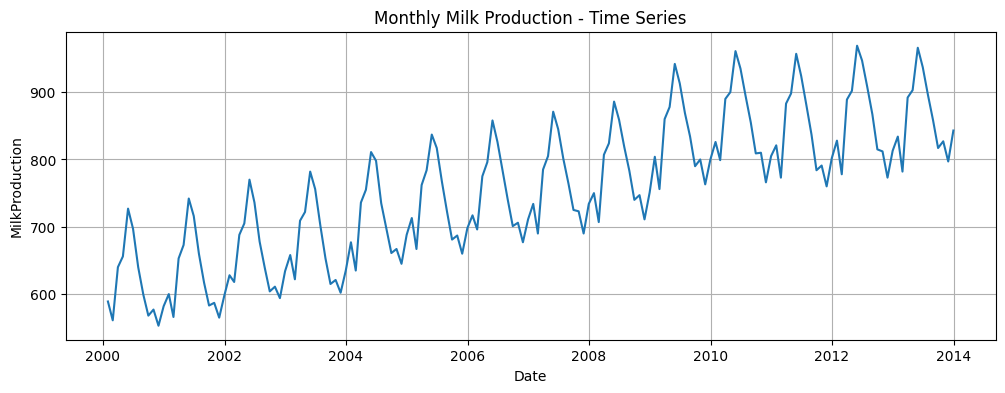

In [19]:
# Plot the time series (single plot - matplotlib)
plt.figure(figsize=(12,4))
plt.plot(series.index, series.values)
plt.title("Monthly Milk Production - Time Series")
plt.xlabel("Date")
plt.ylabel(prod_col)
plt.grid(True)
plt.show()

In [20]:
# Check missing values and basic statistics
print("\nMissing values count:", series.isna().sum())
print("\nBasic stats:")
print(series.describe())


Missing values count: 0

Basic stats:
count    168.000000
mean     754.708313
std      102.204521
min      553.000000
25%      677.750000
50%      761.000000
75%      824.500000
max      969.000000
Name: MilkProduction, dtype: float64


In [21]:
# If missing, we will forward-fill (common approach) - document this.
if series.isna().sum() > 0:
    print("\nForward-filling missing values.")
    series = series.fillna(method='ffill')

# Step 2: Data preparation for Deep Learning

In [22]:
# Normalize (MinMax) because RNNs converge faster with scaled data.
scaler = MinMaxScaler(feature_range=(0,1))
series_values = series.values.reshape(-1,1)
series_scaled = scaler.fit_transform(series_values)

In [23]:
# Create sequences (sliding window)
def create_sequences(data, window_size):
    """
    Given a 1-D numpy array `data`, create input-output sequences using the specified `window_size`.
    Returns X (samples, window_size, 1) and y (samples, 1).
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [24]:
# Hyperparameters for window and splits (you can tune these)
WINDOW = 12  # months of history to predict next month
train_ratio = 0.70
val_ratio = 0.15  # test_ratio is remainder


In [25]:
# Create sequences
X_all, y_all = create_sequences(series_scaled, WINDOW)

In [26]:
# Split respecting time order
n_total = len(X_all)
n_train = int(n_total * train_ratio)
n_val = int(n_total * (train_ratio + val_ratio))

X_train = X_all[:n_train]
y_train = y_all[:n_train]
X_val = X_all[n_train:n_val]
y_val = y_all[n_train:n_val]
X_test = X_all[n_val:]
y_test = y_all[n_val:]

print(f"\nData shapes: X_train={X_train.shape}, y_train={y_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")



Data shapes: X_train=(109, 12, 1), y_train=(109, 1), X_val=(23, 12, 1), X_test=(24, 12, 1)


# Step 3: Model building (RNN, LSTM, GRU)

In [27]:
# We'll create a helper to build comparable models with configurable cell type.

def build_model(cell_type='LSTM', window=WINDOW, units=64, lr=0.001):
    """
    Builds and returns a compiled Keras Sequential model with the specified recurrent cell type.
    cell_type: 'RNN' for SimpleRNN, 'LSTM', or 'GRU'
    """
    model = Sequential()
    if cell_type == 'RNN':
        model.add(SimpleRNN(units, activation='tanh', input_shape=(window,1)))
    elif cell_type == 'LSTM':
        model.add(LSTM(units, activation='tanh', input_shape=(window,1)))
    elif cell_type == 'GRU':
        model.add(GRU(units, activation='tanh', input_shape=(window,1)))
    else:
        raise ValueError("cell_type must be 'RNN', 'LSTM' or 'GRU'")
    model.add(Dense(1))  # predict single scalar (next month's scaled production)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [28]:
# Build all three models
units = 64
rnn_model = build_model('RNN', WINDOW, units)
lstm_model = build_model('LSTM', WINDOW, units)
gru_model = build_model('GRU', WINDOW, units)

# Print model summaries briefly
print("\nRNN model summary:")
rnn_model.summary()
print("\nLSTM model summary:")
lstm_model.summary()
print("\nGRU model summary:")
gru_model.summary()


RNN model summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)


LSTM model summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)


GRU model summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

# Training settings

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)
]

EPOCHS = 150
BATCH = 16

# Train RNN
print("\nTraining SimpleRNN...")
history_rnn = rnn_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=2)

# Train LSTM
print("\nTraining LSTM...")
history_lstm = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                              epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=2)

# Train GRU
print("\nTraining GRU...")
history_gru = gru_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=EPOCHS, batch_size=BATCH, callbacks=callbacks, verbose=2)



Training SimpleRNN...
Epoch 1/150
7/7 - 3s - 388ms/step - loss: 0.0576 - mae: 0.1937 - val_loss: 0.0167 - val_mae: 0.1042 - learning_rate: 1.0000e-03
Epoch 2/150
7/7 - 0s - 17ms/step - loss: 0.0117 - mae: 0.0860 - val_loss: 0.0131 - val_mae: 0.0972 - learning_rate: 1.0000e-03
Epoch 3/150
7/7 - 0s - 19ms/step - loss: 0.0078 - mae: 0.0717 - val_loss: 0.0042 - val_mae: 0.0557 - learning_rate: 1.0000e-03
Epoch 4/150
7/7 - 0s - 18ms/step - loss: 0.0055 - mae: 0.0577 - val_loss: 0.0168 - val_mae: 0.1137 - learning_rate: 1.0000e-03
Epoch 5/150
7/7 - 0s - 17ms/step - loss: 0.0035 - mae: 0.0465 - val_loss: 0.0043 - val_mae: 0.0548 - learning_rate: 1.0000e-03
Epoch 6/150
7/7 - 0s - 17ms/step - loss: 0.0030 - mae: 0.0444 - val_loss: 0.0054 - val_mae: 0.0608 - learning_rate: 1.0000e-03
Epoch 7/150
7/7 - 0s - 17ms/step - loss: 0.0025 - mae: 0.0385 - val_loss: 0.0040 - val_mae: 0.0505 - learning_rate: 1.0000e-03
Epoch 8/150
7/7 - 0s - 18ms/step - loss: 0.0020 - mae: 0.0349 - val_loss: 0.0032 - val_

In [30]:
# Save models and scaler for future reuse
model_dir = "/mnt/data/milk_models"
os.makedirs(model_dir, exist_ok=True)
rnn_model.save(os.path.join(model_dir, "rnn_model.h5"))
lstm_model.save(os.path.join(model_dir, "lstm_model.h5"))
gru_model.save(os.path.join(model_dir, "gru_model.h5"))
joblib.dump(scaler, os.path.join(model_dir, "scaler.save"))

print(f"\nModels and scaler saved to {model_dir}")


Models and scaler saved to /mnt/data/milk_models


# Step 4: Model evaluation

In [31]:
def inverse_transform_preds(scaled_preds):
    """Inverse transform scaled predictions back to original units using scaler."""
    return scaler.inverse_transform(np.array(scaled_preds).reshape(-1,1)).flatten()

def compute_metrics(true_scaled, pred_scaled):
    """Compute RMSE, MAE, MAPE on original scale."""
    true = inverse_transform_preds(true_scaled)
    pred = inverse_transform_preds(pred_scaled)
    rmse = math.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / true)) * 100
    return rmse, mae, mape, true, pred



In [36]:
# Evaluate on test set
pred_rnn_test = rnn_model.predict(X_test)
pred_lstm_test = lstm_model.predict(X_test)
pred_gru_test = gru_model.predict(X_test)

rnn_metrics = compute_metrics(y_test, pred_rnn_test)
lstm_metrics = compute_metrics(y_test, pred_lstm_test)
gru_metrics = compute_metrics(y_test, pred_gru_test)

performance = pd.DataFrame({
    "Model": ["SimpleRNN", "LSTM", "GRU"],
    "RMSE": [rnn_metrics[0], lstm_metrics[0], gru_metrics[0]],
    "MAE": [rnn_metrics[1], lstm_metrics[1], gru_metrics[1]],
    "MAPE(%)": [rnn_metrics[2], lstm_metrics[2], gru_metrics[2]]
})

display(performance)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


,Model,RMSE,MAE,MAPE(%)
0,SimpleRNN,17.463890,14.620639,1.676584
1,LSTM,25.944482,20.871771,2.440859
2,GRU,61.793390,52.469967,6.014298


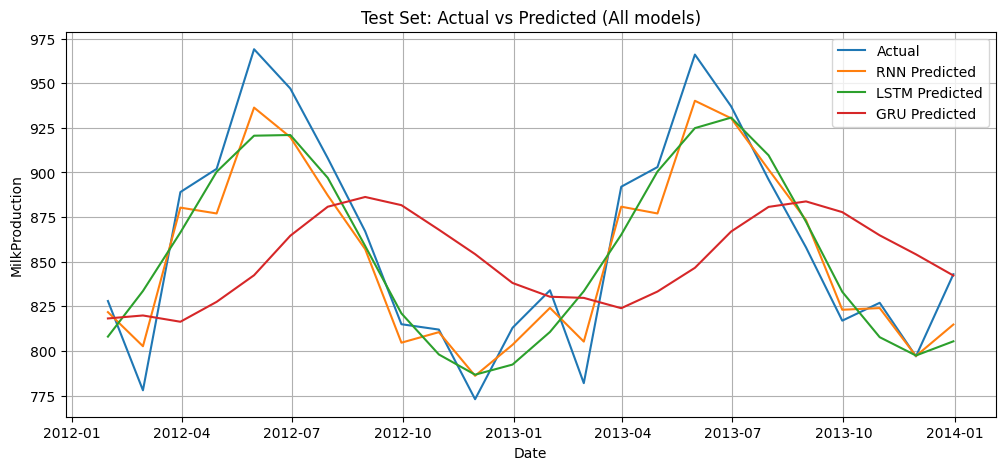

In [37]:
# We'll collect corresponding dates for test y
test_start_idx = WINDOW + n_val  # index in original series where test predictions start
test_dates = series.index[test_start_idx:test_start_idx + len(y_test)]

plt.figure(figsize=(12,5))
plt.plot(test_dates, inverse_transform_preds(y_test), label='Actual')
plt.plot(test_dates, inverse_transform_preds(pred_rnn_test), label='RNN Predicted')
plt.plot(test_dates, inverse_transform_preds(pred_lstm_test), label='LSTM Predicted')
plt.plot(test_dates, inverse_transform_preds(pred_gru_test), label='GRU Predicted')
plt.title("Test Set: Actual vs Predicted (All models)")
plt.xlabel("Date")
plt.ylabel(prod_col)
plt.legend()
plt.grid(True)
plt.show()

# Step 5: Forecasting next 12 months

In [38]:
# We'll use the best-performing model by RMSE (on test) to forecast next 12 months iteratively.
best_idx = performance['RMSE'].idxmin()
best_model_name = performance.loc[best_idx, 'Model']
print(f"\nBest model by RMSE on test set: {best_model_name}")

best_model = {"SimpleRNN": rnn_model, "LSTM": lstm_model, "GRU": gru_model}[best_model_name]



Best model by RMSE on test set: SimpleRNN


In [39]:
# For forecasting, start from the last WINDOW values from the full series_scaled
last_window = series_scaled[-WINDOW:].reshape(1, WINDOW, 1)
forecast_horizon = 12
forecast_scaled = []

current_input = last_window.copy()
for i in range(forecast_horizon):
    next_scaled = best_model.predict(current_input)[0,0]
    forecast_scaled.append(next_scaled)
    # slide window: drop first and append predicted
    new_input = np.concatenate([current_input.flatten()[1:], [next_scaled]])
    current_input = new_input.reshape(1, WINDOW, 1)

forecast = inverse_transform_preds(forecast_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [41]:
# Create forecast index (monthly) starting after last observed date
last_date = series.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_horizon, freq='MS')

forecast_df = pd.DataFrame({"Forecast": forecast}, index=forecast_index)
display(forecast_df)

,Forecast
2014-01-01,832.973633
2014-02-01,811.187500
2014-03-01,880.631958
2014-04-01,881.864075
2014-05-01,934.456665
2014-06-01,917.347168
2014-07-01,893.179688
2014-08-01,868.755249
2014-09-01,828.980469
2014-10-01,839.943665


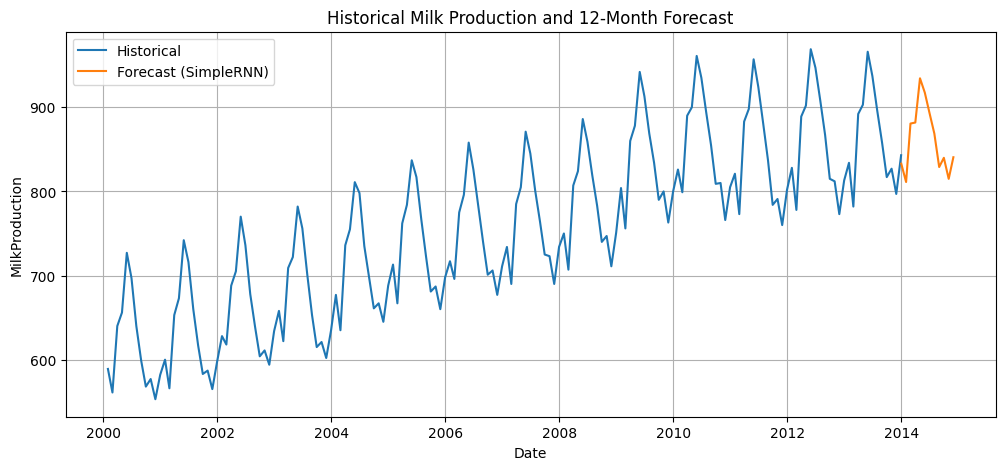

In [42]:
# Plot full series + forecast
plt.figure(figsize=(12,5))
plt.plot(series.index, series.values, label='Historical')
plt.plot(forecast_df.index, forecast_df['Forecast'], label=f'Forecast ({best_model_name})')
plt.title("Historical Milk Production and 12-Month Forecast")
plt.xlabel("Date")
plt.ylabel(prod_col)
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Business insights (printed summary)

In [43]:
print("\nBusiness insights / Recommendations (auto-generated):")
print("- Use the 12-month forecast to plan inventory, storage capacity and procurement.")
print("- If the series shows seasonality, align staffing and distribution to high/low months.")
print("- Monitor model performance over time and retrain periodically (e.g., every 3-6 months) with new data.")
print("- Consider adding exogenous variables (feed costs, weather, holidays) to improve accuracy if available.")

# Save forecast to CSV so user can download
forecast_csv_path = "/mnt/data/monthly_milk_production_forecast_12months.csv"
forecast_df.to_csv(forecast_csv_path)
print(f"\nForecast CSV saved to: {forecast_csv_path}")

# Also save performance table
perf_csv = "/mnt/data/milk_models_performance.csv"
performance.to_csv(perf_csv, index=False)
print(f"Performance CSV saved to: {perf_csv}")

# Final short summary
print("\nDone. The notebook performed EDA, trained SimpleRNN/LSTM/GRU, evaluated them, and produced a 12-month forecast.")
print("Files saved in /mnt/data/:")
for f in ["monthly_milk_production_forecast_12months.csv", "milk_models_performance.csv"]:
    print(" -", f)


Business insights / Recommendations (auto-generated):
- Use the 12-month forecast to plan inventory, storage capacity and procurement.
- If the series shows seasonality, align staffing and distribution to high/low months.
- Monitor model performance over time and retrain periodically (e.g., every 3-6 months) with new data.
- Consider adding exogenous variables (feed costs, weather, holidays) to improve accuracy if available.

Forecast CSV saved to: /mnt/data/monthly_milk_production_forecast_12months.csv
Performance CSV saved to: /mnt/data/milk_models_performance.csv

Done. The notebook performed EDA, trained SimpleRNN/LSTM/GRU, evaluated them, and produced a 12-month forecast.
Files saved in /mnt/data/:
 - monthly_milk_production_forecast_12months.csv
 - milk_models_performance.csv
